In [1]:
import xarray as xr
import numpy as np
import sys; sys.path.append('../')
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

# Drake Passage averages over the last 1000 days

In [38]:
M4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_ann_fct = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-FCT/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_smooth = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_clean = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/ZB-clean-0.5/output/longmean_00029050.nc', decode_times=False).mean('time')
M4_JH = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2-Cback-0.1/output/longmean_00029050.nc', decode_times=False).mean('time')
M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)

In [39]:
#selector = lambda x: x.isel(xh=0)
#selector = lambda x: x.interp(xh=45)
#selector = lambda x: x.interp(xh=30)
selector = lambda x: x.interp(xh=15)

e32 = selector(M32.e).mean('time').compute()
e4 = selector(M4.e).compute()
e4_ann_fct = selector(M4_ann_fct.e).compute()
e4_smooth = selector(M4_smooth.e).compute()
e4_reynolds = selector(M4_reynolds.e).compute()
e4_clean = selector(M4_clean.e).compute()
e4_JH = selector(M4_JH.e).compute()

e32 = e32.interp(yh=e4.yh)

In [ ]:
def plot_interfaces(e, target=e32, xtext=-44, ytext=-3900):
    for zi in range(15):
        e.isel(zi=zi).plot(ls='--', color='blue', lw=2)
        target.isel(zi=zi).plot(ls='-', color='k', lw=2, alpha=0.5)
    e.isel(zi=-1).plot(color='k') # show bathymetry 
    
    error = (e - target).isel(zi=slice(0,15))
    RMSE = np.sqrt((error**2).mean()) # RMSE in metres
    plt.text(xtext,ytext,'RMSE=\n'+"{:.1f}".format(RMSE)+'$\,\mathrm{m}$', fontsize=15)
    plt.xlabel('Latitude, $^{\circ}\mathrm{S}$')
    plt.yticks(np.arange(-4000,1000,1000), np.arange(4000,-1000,-1000))
    plt.ylabel('Depth, $\mathrm{m}$')
    plt.title('')


def plot_interfaces_Drake(e, target=e32):
    plot_interfaces(e,target)
    
    lats = [-60, -50, -40]
    plt.xticks(lats, [f'${-j}$' for j in lats], rotation=0)
    plt.xlim([-61,-39])
    
    # Layer number
    xoff = {2:-42,5:-45,7:-48,9:-50,11:-51,13:-52}
    for k,x in xoff.items():
        plt.text( x, e32.sel(yh=x,method='nearest')[k:k+2].mean(), '%i'%(k+1), verticalalignment='center', fontsize=13)


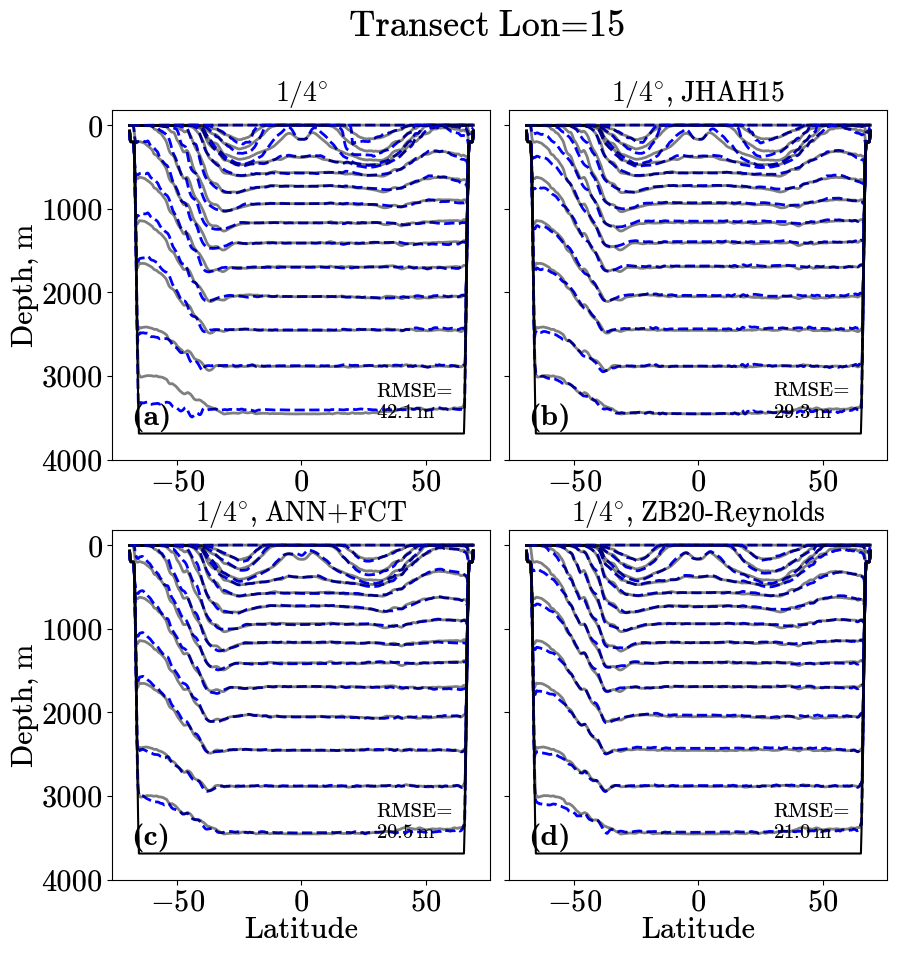

In [14]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.2, 'font.size': 22})
plt.figure(figsize=(10,10))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_ann_fct, e4_reynolds], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15',
         '$1/4^{\circ}$, ANN+FCT', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,2,col+1)
    plot_interfaces(e, target=e32, xtext=30, ytext=-3500)
    plt.title(label, fontsize=20)
    plt.xlabel('Latitude')
    if col==1 or col==3:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
#        plt.xticks([-60, -50, -40], [None]*3)
# plt.plot(np.nan,np.nan,color='k', ls='-', lw=1, label='$1/32^o$')
# plt.legend(loc='lower right', fontsize=10)

        
set_letters(fontsize=20, x=0.05,y=0.1)
plt.suptitle('Transect Lon=15')
plt.savefig('ANN-FCT/NW2-Transect-15.pdf')

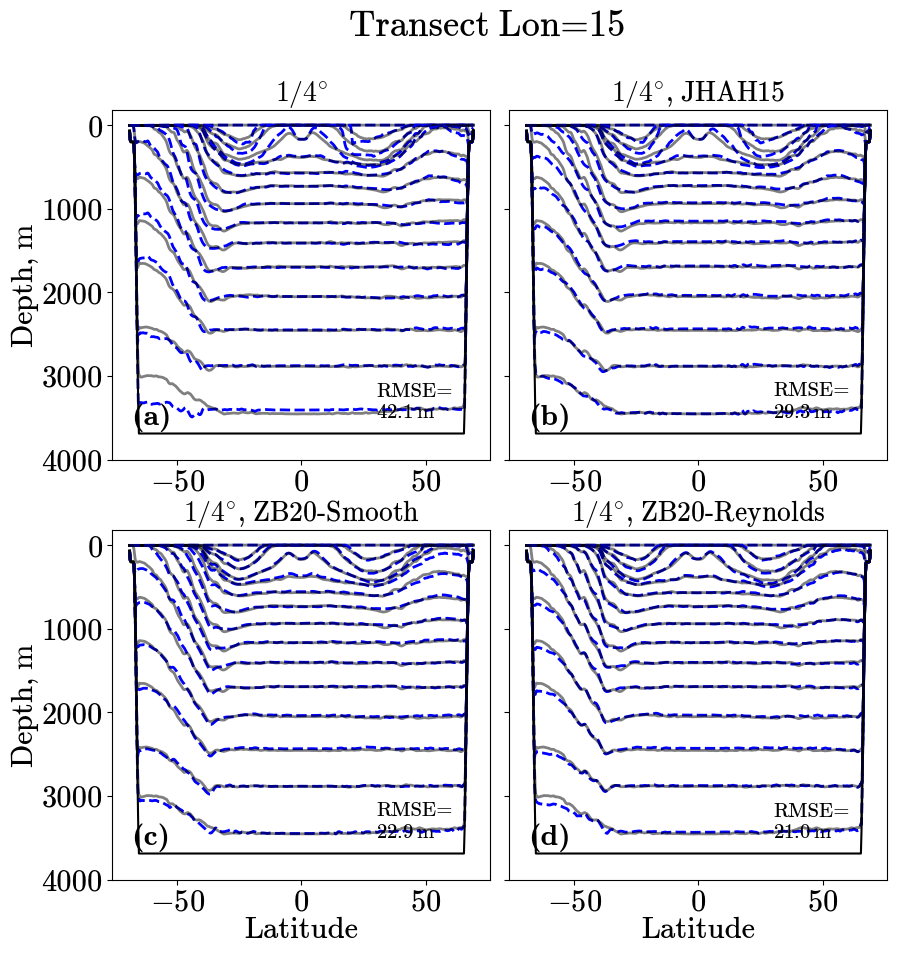

In [40]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.2, 'font.size': 22})
plt.figure(figsize=(10,10))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_smooth, e4_reynolds], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15',
         '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,2,col+1)
    plot_interfaces(e, target=e32, xtext=30, ytext=-3500)
    plt.title(label, fontsize=20)
    plt.xlabel('Latitude')
    if col==1 or col==3:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
#        plt.xticks([-60, -50, -40], [None]*3)
# plt.plot(np.nan,np.nan,color='k', ls='-', lw=1, label='$1/32^o$')
# plt.legend(loc='lower right', fontsize=10)

        
set_letters(fontsize=20, x=0.05,y=0.1)
plt.suptitle('Transect Lon=15')
plt.savefig('ANN-FCT/NW2-Transect-15-Smooth.pdf')

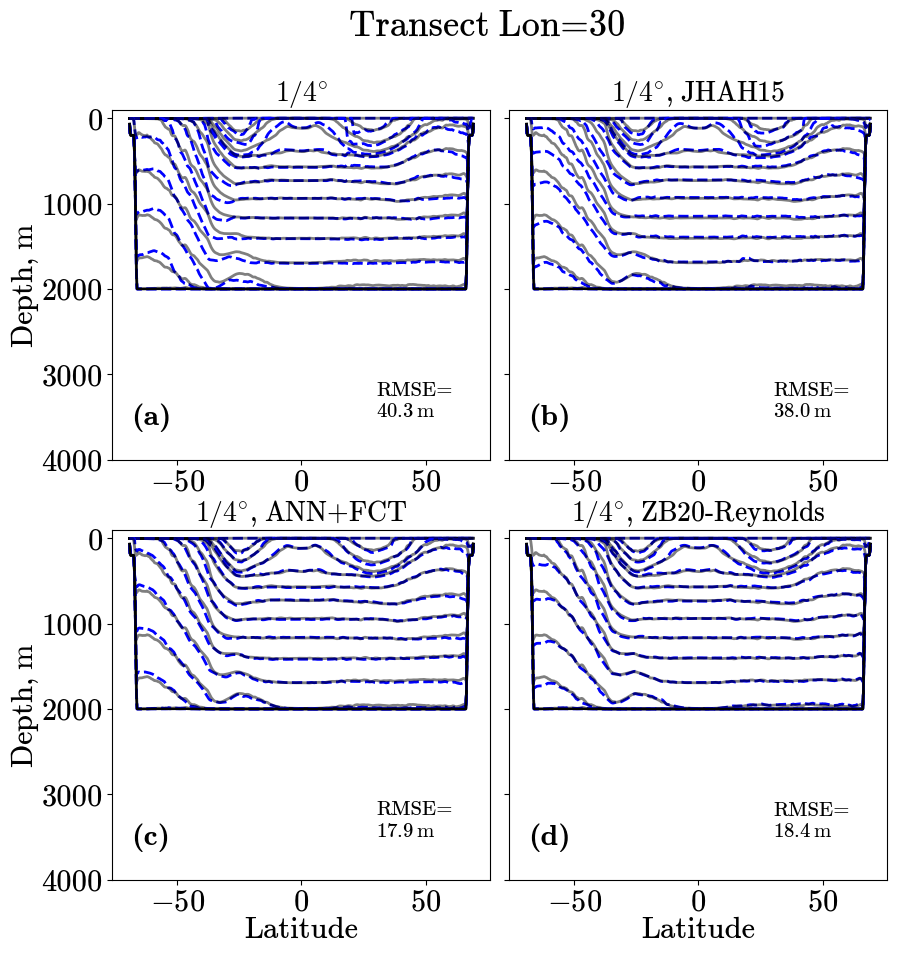

In [12]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.2, 'font.size': 22})
plt.figure(figsize=(10,10))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_ann_fct, e4_reynolds], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15',
         '$1/4^{\circ}$, ANN+FCT', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,2,col+1)
    plot_interfaces(e, target=e32, xtext=30, ytext=-3500)
    plt.title(label, fontsize=20)
    plt.xlabel('Latitude')
    if col==1 or col==3:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
#        plt.xticks([-60, -50, -40], [None]*3)
# plt.plot(np.nan,np.nan,color='k', ls='-', lw=1, label='$1/32^o$')
# plt.legend(loc='lower right', fontsize=10)

        
set_letters(fontsize=20, x=0.05,y=0.1)
plt.suptitle('Transect Lon=30')
plt.savefig('ANN-FCT/NW2-Transect-30.pdf')

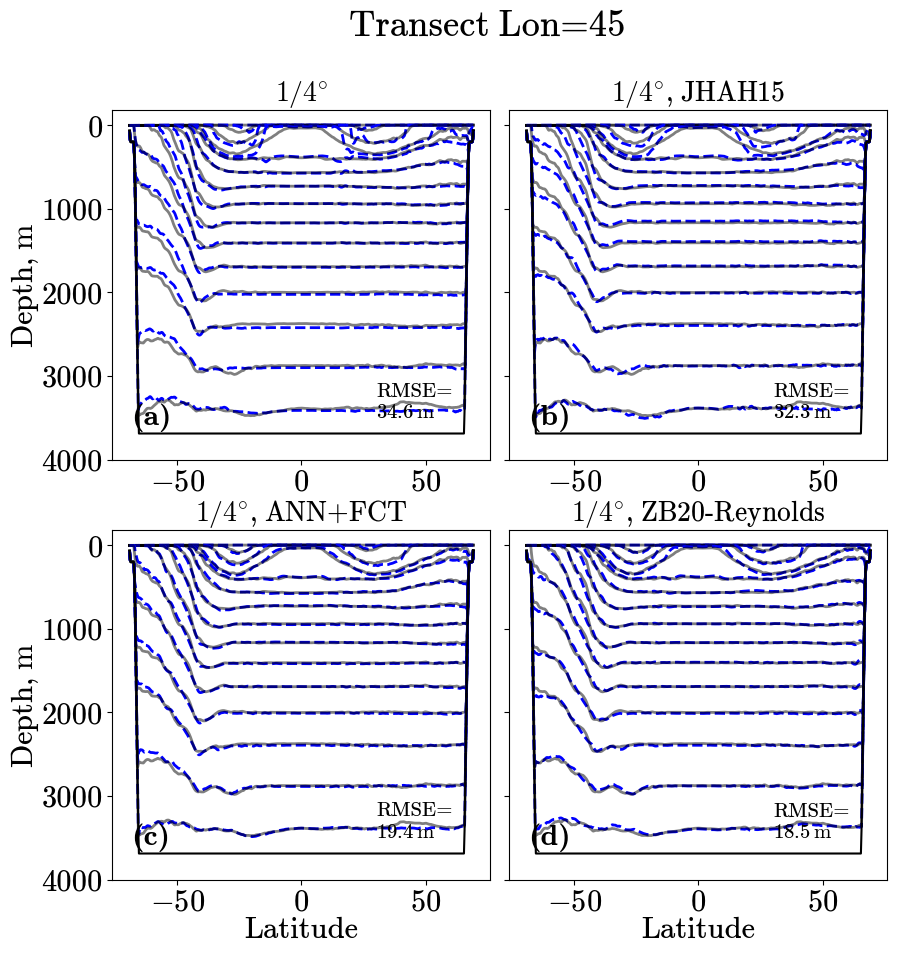

In [10]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.2, 'font.size': 22})
plt.figure(figsize=(10,10))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_ann_fct, e4_reynolds], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15',
         '$1/4^{\circ}$, ANN+FCT', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,2,col+1)
    plot_interfaces(e, target=e32, xtext=30, ytext=-3500)
    plt.title(label, fontsize=20)
    plt.xlabel('Latitude')
    if col==1 or col==3:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
#        plt.xticks([-60, -50, -40], [None]*3)
# plt.plot(np.nan,np.nan,color='k', ls='-', lw=1, label='$1/32^o$')
# plt.legend(loc='lower right', fontsize=10)

        
set_letters(fontsize=20, x=0.05,y=0.1)
plt.suptitle('Transect Lon=45')
plt.savefig('ANN-FCT/NW2-Transect-45.pdf')

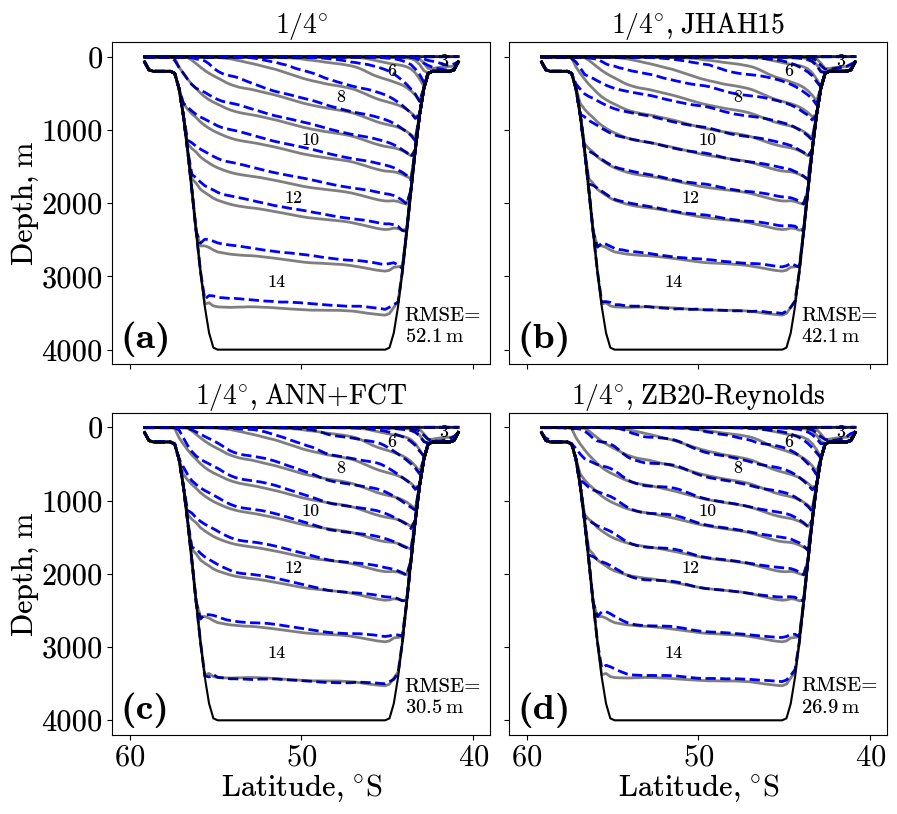

In [7]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 22})
plt.figure(figsize=(10,9))
for col, (e, label) in enumerate(
    zip(
        [e4, e4_JH, e4_ann_fct, e4_reynolds], 
        ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15',
         '$1/4^{\circ}$, ANN+FCT', '$1/4^{\circ}$, ZB20-Reynolds']
        )
    ):
    plt.subplot(2,2,col+1)
    plot_interfaces_Drake(e, target=e32)
    plt.title(label, fontsize=20)
    if col==1 or col==3:
        plt.ylabel('')
        plt.yticks(np.arange(-4000,1000,1000), ['']*5)
    if col==0 or col==1:
        plt.xlabel('')
        plt.xticks([-60, -50, -40], [None]*3)
# plt.plot(np.nan,np.nan,color='k', ls='-', lw=1, label='$1/32^o$')
# plt.legend(loc='lower right', fontsize=10)

        
set_letters(fontsize=25, x=0.02,y=0.05)
plt.savefig('ANN-FCT/NW2-Drake.pdf')

# Mean SSH

In [15]:
ssh_32 = M32.e.isel(zi=0).mean('time').coarsen(xh=8,yh=8).mean().compute()
ssh_4 = M4.e.isel(zi=0).compute()
ssh_reynolds = M4_reynolds.e.isel(zi=0).compute()
ssh_ann_fct = M4_ann_fct.e.isel(zi=0).compute()
ssh_jh = M4_JH.e.isel(zi=0).compute()
ssh_clean = M4_clean.e.isel(zi=0).compute()

In [17]:
for model in [ssh_4, ssh_jh, ssh_ann_fct, ssh_reynolds, ssh_clean]:
    error = model - ssh_32
    rmse = float(np.sqrt((error**2).mean()))
    print("{:.3f}".format(rmse))

0.101
0.110
0.072
0.080
0.097


Text(0.5, 1.0, 'ZB20-Reynolds')

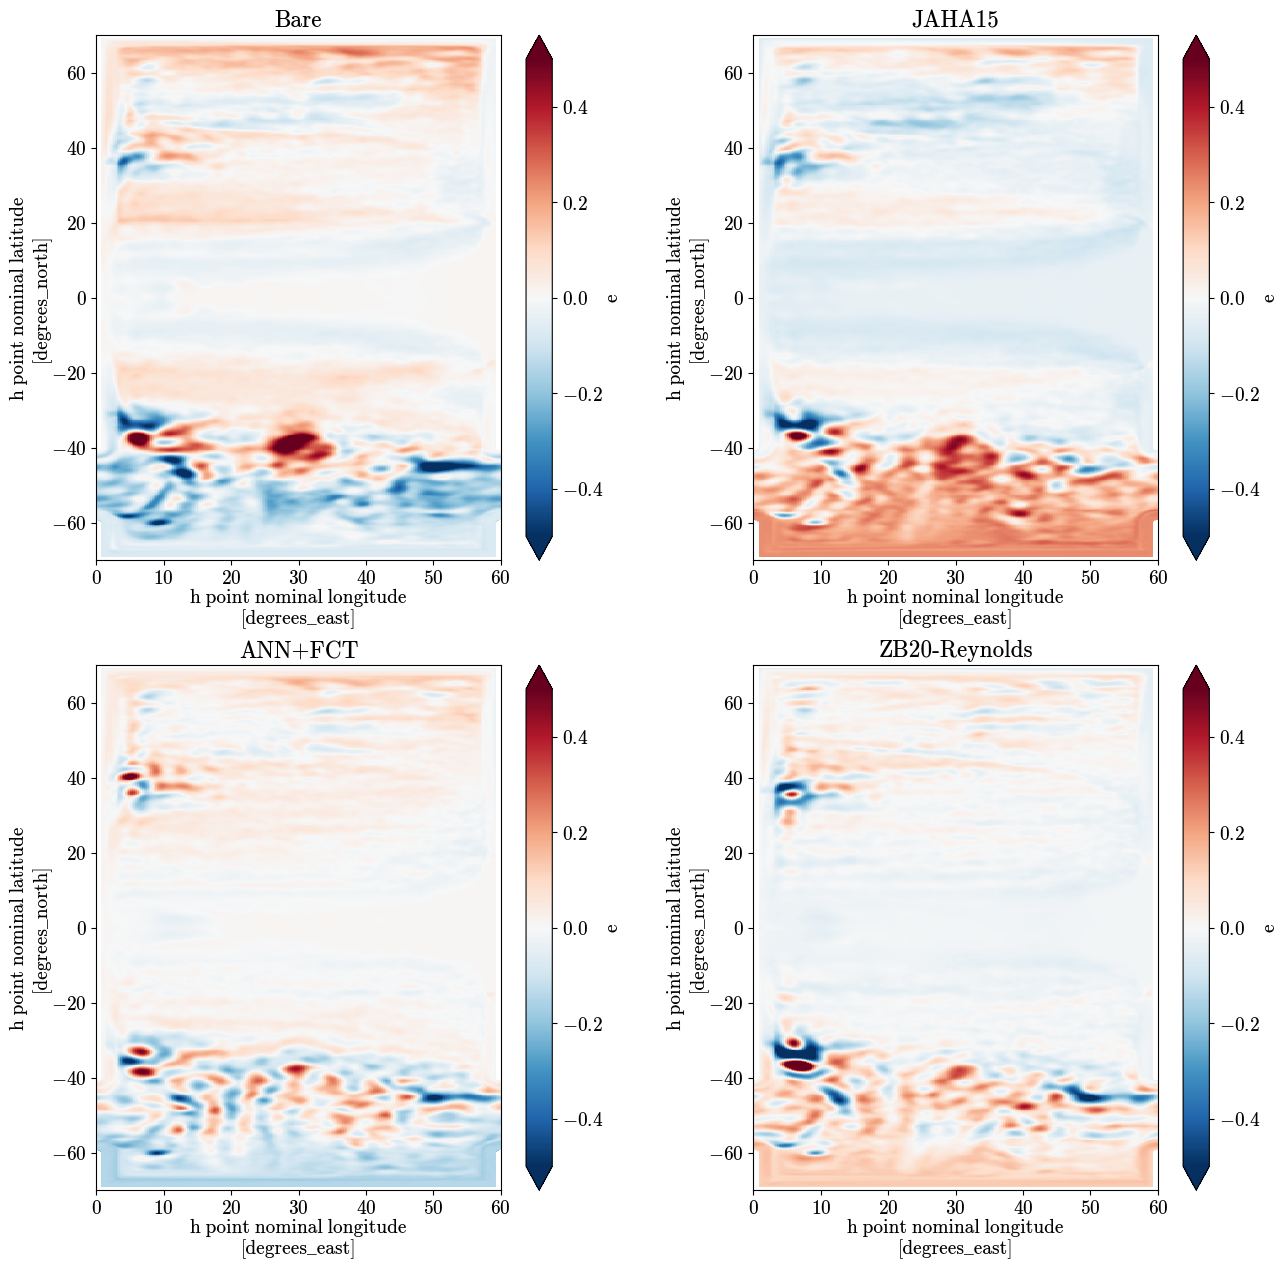

In [18]:
default_rcParams()
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
(ssh_4-ssh_32).plot(vmax=0.5)
plt.title('Bare')

plt.subplot(2,2,2)
(ssh_jh-ssh_32).plot(vmax=0.5)
plt.title('JAHA15')

plt.subplot(2,2,3)
(ssh_ann_fct-ssh_32).plot(vmax=0.5)
plt.title('ANN+FCT')

plt.subplot(2,2,4)
(ssh_reynolds-ssh_32).plot(vmax=0.5)
plt.title('ZB20-Reynolds')


# Snapshot

In [19]:
def e_to_h(e, h):
    thickness = h * 0
    
    for zl in range(len(h.zl)):
        thickness[{'zl':zl}] = e.isel(zi=zl)-e.isel(zi=zl+1)
    
    return thickness

In [20]:
R32f = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False).isel(time=-1)
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_ann_fct = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-FCT/output/snapshots_00029030.nc', decode_times=False).isel(time=-1)
R4_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_jh = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2-Cback-0.1/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)

In [21]:
R32f['h'] = e_to_h(R32f.e, R32f.h)

In [22]:
def KEz(ds):
    return 0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl')

subsample
Colorbar-like object skipped


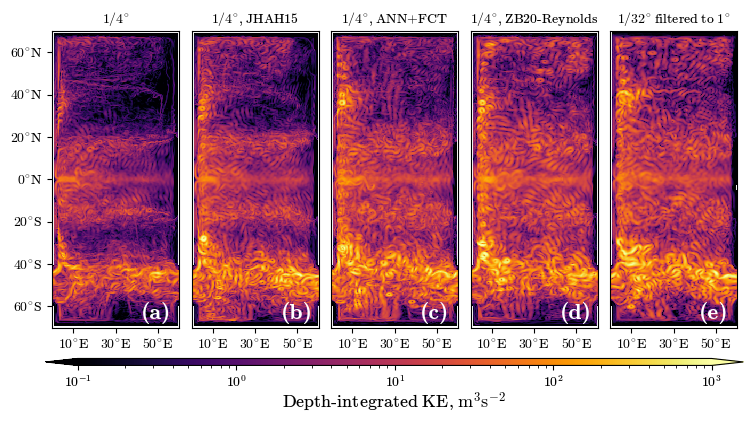

In [23]:
import matplotlib as mpl

default_rcParams({'figure.subplot.wspace': 0.0, 'figure.subplot.hspace': 0.3, 'font.size': 10})

plt.figure(figsize=(9,5))
for col, (exp, label) in enumerate(
    zip(
    [R4, R4_jh, R4_ann_fct, R4_reynolds, R32f],
    ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, ANN+FCT', '$1/4^{\circ}$, ZB20-Reynolds', '$1/32^{\circ}$ filtered to $1^{\circ}$']
    )):
    plt.subplot(1,5,col+1)
    KE = KEz(exp)
    if col==4:
        print('subsample')
        KE = KE.isel(xh=slice(None,None,8), yh=slice(None,None,8))
    im = KE.plot.imshow(
        norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
        cmap='inferno',
        add_colorbar=False,
        interpolation='none'
    )
    plt.gca().axes.set_aspect('equal')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(label, fontsize=10)
    lons = [10,30,50]
    plt.xticks(lons, [f'${lon}^'+'{\circ}$E' for lon in lons])
    if col==0:
        lats = [-60, -40, -20, 0, 20, 40, 60]
        lat_ticks = [f'${-lat}^'+'{\circ}$S' if lat<0 else f'${lat}^'+'{\circ}$N' for lat in lats]
        plt.yticks(lats, lat_ticks)
    else:
        plt.yticks([])
        
plt.colorbar(im, pad=0.08, aspect=100, orientation='horizontal', ax=plt.gcf().axes, extend='both').set_label(fontsize=13, label='Depth-integrated KE, $\mathrm{m}^3 \mathrm{s}^{-2}$')
set_letters(x=0.7, y=0.03, fontsize=15, color='white')
plt.savefig('ANN-FCT/NW2-snapshot.pdf')

# KE spectrum of surface velocities

In [24]:
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))
R4_ann_fct = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-FCT/output/snapshots_00029030.nc', decode_times=False).isel(time=slice(-4,None))
R4_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))
R4_jh = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2-Cback-0.1/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-4,None))

R32f_R1 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False)
R32f_R2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-snapshots.nc', decode_times=False)
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots_00002705.nc', decode_times=False).isel(time=slice(None,None,6))

In [25]:
M4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False)
M4_ann_fct = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-FCT/output/longmean_00029050.nc', decode_times=False)
M4_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/longmean_00029050.nc', decode_times=False)
M4_jh = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2-Cback-0.1/output/longmean_00029050.nc', decode_times=False)

M32f_R1 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-longmean.nc', decode_times=False)
M32f_R2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-longmean.nc', decode_times=False)
M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)

In [26]:
import xrft
def KE_spectrum(u, v, dx_mean=1):    
    x = dx_mean*np.arange(len(u.xh))
    u['xh'] = x
    v['xh'] = x
    
    spec = lambda val: xrft.power_spectrum(val, dim='xh', window='hann', nfactor=2,truncate=True, detrend='linear', window_correction=False)
    
    # KE is half the power spectrum
    sp = (spec(u) + spec(v))/2
    
    # Normalize to angular frequencies
    sp['freq_xh'] = sp['freq_xh'] * 2 * np.pi
    sp = sp / (2 * np.pi)
    freq = sp.freq_xh
    sp = sp.where(freq>0)
    
    return sp.mean('time').compute()

In [27]:
def SKE_spectrum(ds, ds_mean):
    ssu = ds.u.isel(zl=0) - ds_mean.u.isel(zl=0).mean('time')
    ssv = ds.v.isel(zl=0) - ds_mean.v.isel(zl=0).mean('time')
    
    ssu = remesh(ssu, ds.h)
    ssv = remesh(ssv, ds.h)
    
    # remove 2.5 Lon from boundaries similarly to Marques
#     ssu = ssu.sel(xh = slice(2.5, 57.5))
#     ssv = ssv.sel(xh = slice(2.5, 57.5))
    
    if len(ds.xh)==240:
        dx_mean = 21383.6332011
    elif len(ds.xh)==1920:
        dx_mean = 21383.6332011 / 8
    else:
        print('Define dx_mean')
    
    return KE_spectrum(ssu,ssv,dx_mean)

In [28]:
from dask.diagnostics import ProgressBar

In [29]:
with ProgressBar():
    R32_spec = SKE_spectrum(R32,M32)
    R32f_R1_spec = SKE_spectrum(R32f_R1,M32f_R1)
    R32f_R2_spec = SKE_spectrum(R32f_R2,M32f_R2)
    R4_spec = SKE_spectrum(R4,M4)
    ann_fct_spec = SKE_spectrum(R4_ann_fct,M4_ann_fct)
    reynolds_spec = SKE_spectrum(R4_reynolds,M4_reynolds)
    jh_spec = SKE_spectrum(R4_jh,M4_jh)

[########################################] | 100% Completed | 33.09 s
[########################################] | 100% Completed | 11.88 s
[########################################] | 100% Completed | 11.94 s
[########################################] | 100% Completed | 1.32 sms
[########################################] | 100% Completed | 1.32 sms
[########################################] | 100% Completed | 1.32 sms
[########################################] | 100% Completed | 1.22 sms


(0.0001, 10000.0)

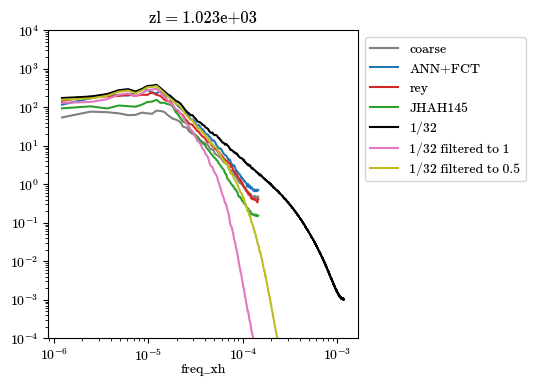

In [31]:
sel = lambda x : x.sel(yh=slice(None,None)).mean('yh')
sel(R4_spec).plot(color='gray', label='coarse')
sel(ann_fct_spec).plot(color='tab:blue', label='ANN+FCT')
sel(reynolds_spec).plot(color='tab:red', label='rey')
sel(jh_spec).plot(color='tab:green', label='JHAH145')
sel(R32_spec).plot(color='k', label='1/32')
sel(R32f_R1_spec).plot(color='tab:pink', label='1/32 filtered to 1')
sel(R32f_R2_spec).plot(color='tab:olive', label='1/32 filtered to 0.5')
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.ylim([1e-4,1e+4])

## Combined figure

In [32]:
yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

In [33]:
stats_R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_ann_fct = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-FCT/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_reynolds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()
stats_jh = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2-Cback-0.1/output/ocean.stats.nc', decode_times=False).coarsen({'Time':50}, boundary='trim').mean()

In [34]:
def KE(ds):
    return ds.KE.sum('Layer')
def APE(ds):
    return ds.APE.sum('Interface')

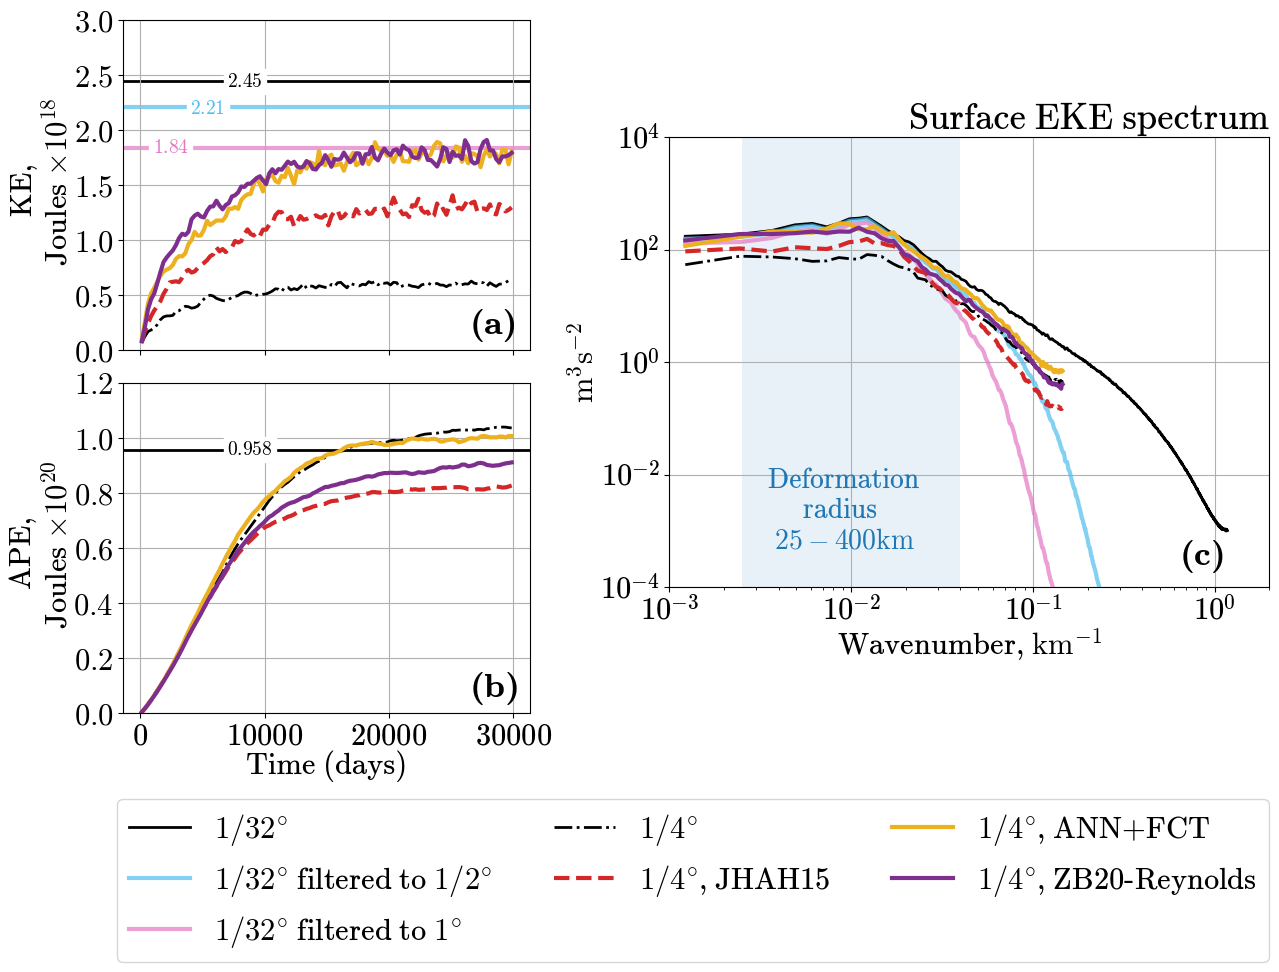

In [35]:
default_rcParams({'figure.subplot.wspace': 0.8, 'figure.subplot.hspace': 0.1,
                  'font.size': 22,  'axes.formatter.limits': (-5,5),
                 })
fig = plt.figure(figsize=(12,9))
import matplotlib.colors as mcolors

gs = fig.add_gridspec(2,4)

plt.sca(fig.add_subplot(gs[0, 0:2]))

plt.axhline(y=2.4482846764501053e+18, color='k', ls='-', lw=2, zorder=-1, label='$1/32^{\circ}$')
plt.axhline(y=2.2143647793008573e+18, color=lightblue, ls='-', lw=3, alpha=0.7, zorder=-1, label='$1/32^{\circ}$ filtered to $1/2^{\circ}$')
plt.axhline(y=1.840343192972326e+18, color='tab:pink', ls='-', lw=3, alpha=0.7, zorder=-1, label='$1/32^{\circ}$ filtered to $1^{\circ}$')

plt.text(7000,2.4e+18,'$2.45$', backgroundcolor='white', color='k', fontsize=14)
plt.text(4000,2.15e+18,'$2.21$', backgroundcolor='white', color=lightblue, fontsize=14)
plt.text(1000,1.8e+18,'$1.84$', backgroundcolor='white', color='tab:pink', fontsize=14)


KE(stats_R4).plot(color='k', ls='-.', label='$1/4^{\circ}$', lw=2)
KE(stats_jh).plot(color='tab:red', label='$1/4^{\circ}$, JHAH15', lw=3, ls='--')
KE(stats_ann_fct).plot(color=yellow, label='$1/4^{\circ}$, ANN+FCT', lw=3)
KE(stats_reynolds).plot(color=violet, label='$1/4^{\circ}$, ZB20-Reynolds', lw=3, ls='-')


plt.ylabel('KE, \n Joules $\\times 10^{18}$')
plt.ylim([0, 3e+18])
plt.yticks([0, 0.5e+18,1e+18,1.5e+18,2.0e+18,2.5e+18,3e+18], ['$0.0$', '$0.5$', '$1.0$', '$1.5$', '$2.0$', '$2.5$', '$3.0$'])
#plt.yticks([0, 0.6e+18,1.2e+18,1.8e+18,2.4e+18,3.0e+18], ['$0.0$', '$0.6$', '$1.2$', '$1.8$', '$2.4$', '$3.0$'])
plt.xlabel('')
plt.xticks([0, 10000, 20000, 30000], [None]*4)
plt.grid()

plt.legend(loc = 'lower center', fontsize=22, bbox_to_anchor=(1.4,-1.9), ncol=3)

plt.sca(fig.add_subplot(gs[1, 0:2]))
plt.axhline(y=9.584091697350959e+19, color='k', ls='-', lw=2)
plt.text(7000,9.4e+19,'$0.958$', backgroundcolor='white', color='k', fontsize=14)


APE(stats_R4).plot(color='k', label='$1/4^{\circ}$', lw=2, ls='-.')
APE(stats_jh).plot(color='tab:red', label='$1/4^{\circ}$, JHAH15', lw=3, ls='--')
APE(stats_ann_fct).plot(color=yellow, label='$1/4^{\circ}$, ANN+FCT', lw=3)
APE(stats_reynolds).plot(color=violet, label='$1/4^{\circ}$, ZB-Reynolds', lw=3, ls='-')

plt.ylabel('APE, \n Joules $\\times 10^{20}$')
#plt.title('APE',loc='right')
plt.ylim([0, 1.2e+20])
plt.grid()

plt.yticks([0, 0.2e+20, 0.4e+20, 0.6e+20, 0.8e+20, 1.0e+20, 1.2e+20], ["$0.0$", "$0.2$", "$0.4$", "$0.6$", "$0.8$", "$1.0$", "$1.2$"])
#plt.yticks([0, 0.3e+20, 0.6e+20, 0.9e+20, 1.2e+20], ["$0.0$", "$0.3$", "$0.6$", "$0.9$", "$1.2$"])

plt.xlabel('Time (days)')


#plt.sca(fig.add_subplot(gs[0:2, 2:4]))
ax = plt.gcf().add_axes([0.58, 0.25, 0.5,0.5])
plt.sca(ax)
def sel(x):
    y = x.sel(yh=slice(None,None)).mean('yh')
    y['freq_xh'] = y['freq_xh'] * 1e+3
    return y
sel(R32_spec).plot(color='k', ls='-', lw=2)
sel(R32f_R2_spec).plot(color=lightblue, ls='-', lw=3, alpha=0.7)
sel(R32f_R1_spec).plot(color='tab:pink', ls='-', lw=3, alpha=0.7)

sel(R4_spec).plot(color='k', lw=2, ls='-.')
sel(jh_spec).plot(color='tab:red', lw=3, ls='--')
sel(ann_fct_spec).plot(color=yellow, lw=3)
sel(reynolds_spec).plot(color=violet, lw=3, ls='-')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,1e+4])
plt.yticks([1e-4, 1e-2, 1e0, 1e+2, 1e+4])
plt.title('Surface EKE spectrum', loc='right')
plt.title('')
plt.ylabel('$\mathrm{m}^3\mathrm{s}^{-2}$')
plt.xlabel('Wavenumber, $\mathrm{km}^{-1}$')
plt.xticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlim([1e-3, 2])
plt.grid()

Rd1 = 400
Rd2 = 25
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(3.5e-3,5e-4,'Deformation \n     radius \n $25-400\mathrm{km}$', fontsize=20, color='tab:blue')


# k = np.array([1e-2,1e0])
# plt.plot(k, 3e-1*k**(-2))

#plt.gcf().align_labels()
set_letters(x=0.85, y=0.05, fontsize=24)
plt.savefig('ANN-FCT/NW2-spectrum.pdf')